# Recommendations with IBM

In this notebook, I build out a number of different methods for making recommendations to use on real data from the IBM Watson Studio platform. Then, I create a class to combine all the recommendations methods for specific circumstances. Finally, the recommendation engine is deployed as a Streamlit web app.<br><br>
This is the 3rd graded project of Udacity's [Data Scientist nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025). For grading purposes, several functions included in the `project_tests.py`script are used througout this notebook to check my answers to several questions (see below).


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Recommender class - OOP (EXTRA)](#oop)<br>
VII. [Deployment (EXTRA)](#deployment)<br>
VII. [Conclusions](#conclusions)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t # grading script
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [3]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset? 

`1a.` *Article views (non-unique articles) per user:*

In [5]:
# user-item interactions are in df. USers can be identified by email column. If number of users is lower than number of 
# rows, it means a single user has interacted with more than one article
n_interactions = len(df)
n_unique_users = df['email'].nunique()
n_unique_articles = df['article_id'].nunique()
interactions_per_user = n_interactions / n_unique_users
print("Number of interactions (views) = {}\nNumber of unique users = {}\nAverage number of interactions per user = {}\nNumber of unique articles = {}". format(n_interactions, n_unique_users, round(interactions_per_user,1), n_unique_articles))

Number of interactions (views) = 45993
Number of unique users = 5148
Average number of interactions per user = 8.9
Number of unique articles = 714


In [6]:
# Some statistics on the distribution of article views per user:
df_views_user = df[['email','title']].groupby(['email']).count().rename(columns={'title':'n_views'})
min_views_by_user = df_views_user['n_views'].min()
max_views_by_user = df_views_user['n_views'].max()
median_val = df_views_user['n_views'].median() # 50% of individuals interact with ____ number of articles or fewer.
print("Min number of views per user = {}\nMax number of views per user = {}\nMedian number of views per user = {}".format(min_views_by_user,max_views_by_user,median_val))

Min number of views per user = 1
Max number of views per user = 364
Median number of views per user = 3.0


Text(0, 0.5, 'Number of unique users')

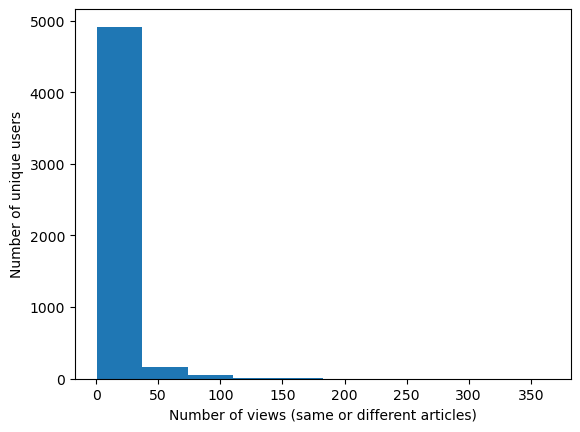

In [7]:
# Visual plot of the distribution of article views per user: most users view a few articles only
plt.hist(df_views_user)
plt.xlabel("Number of views (same or different articles)")
plt.ylabel("Number of unique users")

`1b.` *Unique article views per each user:*

In [8]:
# How many different articles does each user view?
df_articles_user = df[['email','article_id']].groupby(['email']).nunique().rename(columns={'article_id':'n_articles'})
min_articles = df_articles_user['n_articles'].min()
median_articles = df_articles_user['n_articles'].median()
max_articles = df_articles_user['n_articles'].max()
print("Min number of articles = {}\nMedian number of articles = {}\nMax number of articles = {}".format(min_articles, median_articles, max_articles))

Min number of articles = 1
Median number of articles = 3.0
Max number of articles = 135


`2.` Remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles
for col in df_content.columns:
    print("column '{}' : {} duplicated cells".format(col, df_content[col].duplicated().sum()))

column 'doc_body' : 19 duplicated cells
column 'doc_description' : 33 duplicated cells
column 'doc_full_name' : 5 duplicated cells
column 'doc_status' : 1055 duplicated cells
column 'article_id' : 5 duplicated cells


In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)
for col in df_content.columns:
    print("column '{}' : {} duplicated cells".format(col, df_content[col].duplicated().sum()))

column 'doc_body' : 19 duplicated cells
column 'doc_description' : 31 duplicated cells
column 'doc_full_name' : 0 duplicated cells
column 'doc_status' : 1050 duplicated cells
column 'article_id' : 0 duplicated cells


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
df.isna().sum()

article_id     0
title          0
email         17
dtype: int64

In [12]:
# unique articles that have interaction with user
len(df[['article_id','email']].dropna())

45976

In [13]:
unique_articles = df[['article_id','email']].dropna().nunique()['article_id'] # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
#user_article_interactions = len(df[['article_id','email']].dropna()) # not accepted, because null values are assumed to come from a single user
user_article_interactions = len(df) # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
df_articles_views = df[['article_id','title']].groupby('article_id').count().rename(columns={'title':'views'}).sort_values(by='views', ascending=False).reset_index()
df_articles_views.head()

,article_id,views
0,1429.0,937
1,1330.0,927
2,1431.0,671
3,1427.0,643
4,1364.0,627


In [15]:
most_viewed_article_id = str(df_articles_views.iloc[0]['article_id']) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df_articles_views.iloc[0]['views'] # The most viewed article in the dataset was viewed how many times?

Text(0, 0.5, 'Number of articles')

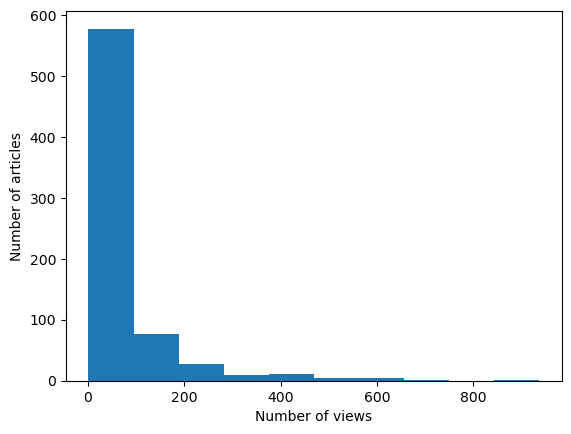

In [16]:
plt.hist(df_articles_views.set_index('article_id'))
plt.xlabel("Number of views")
plt.ylabel("Number of articles")

Thus, EDA plots above show that most users see very few articles and most articles receive very few views. In this situation, it is very unlikely that different users have great similarity in their preferences, so collaborative filtering might be an inefficient way to propose relevant content. Below more on this.

Now, we will prepare data for modelling by encoding a user_id column:

In [17]:
def email_mapper(df=df):
    ''' Maps the user email to a user_id column and remove the email column
    
    INPUT
        None
    OUTPUT:
        None - it creates a column in df dataframe called 'user_id'
    
    '''
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
# Quizz test
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Here, I build a function to retrieve the most popular articles in the platform. <br><br>
Article popularity is computed by the number of views the item has received (each row in `df`dataframe is an interaction between a user and an article).

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [19]:
def get_top_article_ids(n, df=df):
    ''' Returns ids of most popular articles (highest number of views)
    INPUT:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df containing user-article interactions (each row corresponds to
        1 user viewing 1 article) 
    
    OUTPUT:
        top_articles - (list) A list of the top 'n' article ids
    
    '''
    df_articles_views = df[['article_id','title']].groupby('article_id').count().rename(columns={'title':'views'}).sort_values(by='views', ascending=False).reset_index()
    top_ids = df_articles_views.iloc[:n]['article_id'].tolist()  
    top_ids = [str(idx) for idx in top_ids] # convert to string for tests
    return top_ids # Return the top article ids


def get_top_articles(n, df=df):
    ''' Returns titles of most popular articles (highest number of views)
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = []
    top_ids = get_top_article_ids(n, df=df)
    top_ids = [float(idx) for idx in top_ids]
    for idx in top_ids:
        top_articles.append(df[df['article_id']==idx]['title'].iloc[0])
    
    return top_articles # Return the top article titles from df (not df_content)

In [20]:
print(get_top_articles(5))
print(get_top_article_ids(5))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']


In [21]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Let's reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

In [22]:
def create_user_item_df(df):
    """ Creates the user-article matrix in dataframe format with users as rows, articles as columns, and values are 1's and 0's (1 if the user
    has read the article regardless of the number of times he/she has read the same article, 0 otherwise)
    
    INPUT:
        df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
        user_item_df - a dataframe with users as rows, articles as columns and values are 1 if the user has seen the
        article and 0 otherwise 
    """
    # create user_item df with users (ids) as rows, articles (ids) as columns and views as values
    user_item_df = df.groupby(['user_id','article_id'])['title'].count().unstack()
    # replace non-missing values with 1 (any numeric value should be 1) and missing values with 0
    user_item_np = np.matrix(user_item_df)
    np.nan_to_num(user_item_np,0)
    user_item_np[user_item_np>0]=1
    user_item_matrix = pd.DataFrame(user_item_np, columns = user_item_df.columns, index = user_item_df.index)
    return user_item_matrix

def create_user_item_matrix(df):
    ''' Creates the user-article matrix in numpy array format with users as rows, articles as columns, and values are 1's and 0's (1 if the user
    has read the article regardless of the number of times he/she has read the same article, 0 otherwise)
    INPUT:
        df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
        user_item - user item matrix (numpy array)
    
    '''
    user_item_matrix = np.matrix(create_user_item_df(df))
    return user_item_matrix # return the user_item matrix 

In [23]:
user_item = create_user_item_matrix(df)
user_item_df = create_user_item_df(df)

In [24]:
## Tests: 
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[0] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Let's now create a function to find similar users by computing the dot product of the user-item matrix with its transpose to have a measure of user similarity based on the articles they have seen. Then, return the most similar users sorted by similarity, removing the user itself. 

In [25]:
users_dot_prod_np = np.dot(user_item_df,np.transpose(user_item_df))
dot_prod_df = pd.DataFrame(users_dot_prod_np, columns = user_item_df.index, index = user_item_df.index)
#users_dot_prod_df.to_csv('users_dot_product.csv')
#users_dot_prod_df.head()

Ploting the dot product of the user-item matrix with its transpose reveals very little similarity between users in the dataset, as expected above and shown below (note a stark prevalence of dark color in heatmap below):

<AxesSubplot: xlabel='user_id', ylabel='user_id'>

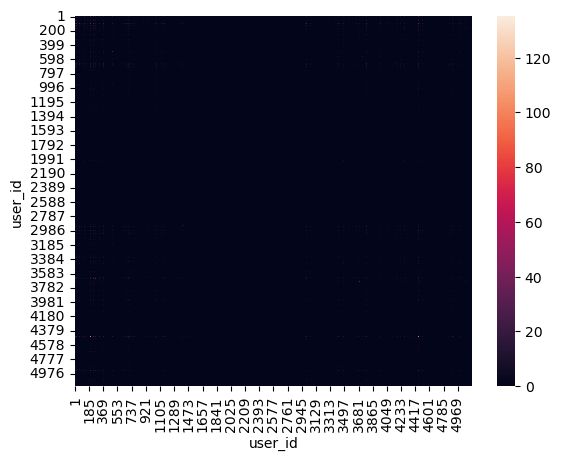

In [26]:
sns.heatmap(dot_prod_df)

In [27]:
def find_similar_users(user_id, users_similarity = dot_prod_df):
    ''' Returns a list of all other users sorted by similarity to input user_id as computed by the dot product
    of the user-item matrix with its transpose.
    
    INPUT:
        user_id - (int) a user_id
        users_similarity (dataframe): a dataframe resulting from the dot product of the user-item matrix with its transpose
        (contains the similarity of all users with all the other users)
    
    OUTPUT:
        similar_users - (list) an ordered list where the closest users (largest dot product users)
        are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    '''
    # sort users by similarity
    user_row = user_id - 1 # df position starts at 0 and user ids start at 1
    sorted_df = users_similarity.iloc[user_row].sort_values(ascending=False)
    # create list of just the user ids
    most_similar_users = sorted_df.index.tolist()
    # remove the own user's id
    most_similar_users.remove(user_id)
    return most_similar_users # return a list of the users in order from most to least similar
        

In [28]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now let's create functions to return the articles to recommend to each user. 

In [29]:
def get_article_names(article_ids, df=df):
    ''' Returns the article names associated with a list of article ids
    
    INPUT:
        article_ids - (list) a list of article ids
        df - (pandas dataframe) df containing user-article interactions (each row corresponds to
        1 user viewing 1 article) 
    
    OUTPUT:
        article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # convert article_ids to float in case  they come as strings
    article_ids = [float(i) for i in article_ids]
    # then store names
    article_names = []
    for item in article_ids:
        try: # if the article id is in df, get name from there
            article_names.append(df[df['article_id']==item]['title'].iloc[0])
        except: # get name from df_content if not in df
            article_names.append(df_content[df_content['article_id']==item]['doc_full_name'].iloc[0])
    return article_names

In [30]:
def get_user_articles_full(user_id, user_item=user_item_df):
    ''' Provides a list of the article_ids and article titles that have been seen by a user
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    '''
    article_ids = []
    user_df = user_item[user_item.index==user_id]
    for article_id in user_df.columns:
        if user_df.iloc[0][article_id] == 1:
            article_ids.append(str(article_id)) # convert article_id to string for tests
    article_names = get_article_names(article_ids, df=df)
    return article_ids, article_names # return the ids and names

In [31]:
def get_user_articles(user_id, user_item=user_item_df):
    ''' Provides a list of ids of the articles that have been seen by a user
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    
    '''
    article_ids = []
    user_df = user_item[user_item.index==user_id]
    for article_id in user_df.columns:
        if user_df.iloc[0][article_id] == 1:
            article_ids.append(str(article_id)) # convert article_id to string for tests
    return article_ids

In [32]:
def user_user_recs(user_id, m=10):
    ''' Makes recommendations for a input user_id based on content liked by similar users. 
    
    INPUT:
        user_id - (int) a user id
        m - (int) the number of recommendations you want for the user
    
    OUTPUT:
        recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    '''
    seen_ids, seen_titles = get_user_articles_full(user_id)
    similar_users = find_similar_users(user_id)
    recs = []
    for user in similar_users:
        #print("\nUser: {}, type: {}".format(user, type(user)))
        # convert user to integer to be able to find it in 'df_users_items' in get_user_articles() function
        user = int(user)
        # get ids of articles seen by that user
        new_ids = get_user_articles(user)
        # save ids in recs
        recs.extend(new_ids)
        # remove articles already seen by input user
        recs = list(set(recs) - set(seen_ids))
        # if number of collected recommendations exceeds m, stop loop
        if len(recs) > m-1:
            break
    return recs[:m] # return your recommendations for this user_id    

In [33]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['how smart catalogs can turn the big data flood into an ocean of opportunity',
 'this week in data science (april 18, 2017)',
 'a tensorflow regression model to predict house values',
 'using github for project control in dsx',
 'perform sentiment analysis with lstms, using tensorflow',
 'spark-based machine learning tools for capturing word meanings',
 'using deep learning with keras to predict customer churn',
 'visualize data with the matplotlib library',
 'leverage python, scikit, and text classification for behavioral profiling',
 'analyze precipitation data']

In [34]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles_full(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles_full(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles_full(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles_full(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user, choose articles with the most total interactions before choosing those with fewer total interactions.

In [35]:
def get_top_sorted_users(user_id, df=df, users_similarity = dot_prod_df):
    ''' Gives a list of users that are most similar to the input user_id and that are the most active
    
    INPUT:
        user_id - (int)
        df - (pandas dataframe) df containing user-article interactions (each row corresponds to 1 user viewing 1 article)
        users_similarity (dataframe): a dataframe resulting from the dot product of the user-item matrix with its transpose
        (contains the similarity of all users with all the other users)
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # load dot_product_df and get row of user_id from users_similarity dataframe
    #dot_prod_df = pd.read_csv('users_dot_product.csv')
    #dot_prod_df.set_index('user_id', inplace=True)
    #user_df = dot_prod_df[dot_prod_df.index==user_id]
    user_df = users_similarity[users_similarity.index==user_id]
    
    # transpose row to have column of similarity and index = neighbour id
    user_df_transpose = user_df.transpose().rename(columns={user_id:'simmilarity'})
    
    # append number of articles viewed by user. One option is unique articles. Another option is total views
    user_df_transpose.index = user_df_transpose.index.astype(int)
    user_df_transpose.index.name = 'user_id'
    df_views_users = df[['user_id','title']].groupby(['user_id']).count().rename(columns={'title':'n_views'}) # total views
    neighbors_df = user_df_transpose.merge(df_views_users, on='user_id')
    
    # sort 
    neighbors_df.sort_values(by=['simmilarity','n_views'], ascending=False, inplace=True)

    # remove input user
    neighbors_df = neighbors_df[neighbors_df.index != user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string


In [36]:
def user_user_recs_part2(user_id, m=10):
    ''' Gives recommendations to a user_id by pulling articles seen by similar users, sorted by user and article activity 
    in the platform (similar users with highest interactions are considered first, and articles with highest number of
    views are also considered first)
    
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get articles seen by user
    seen_ids = get_user_articles(user_id)
    # Find similar users, favouring users with more interactions
    similar_users = get_top_sorted_users(user_id, df=df).index.tolist()
    # Loop over similar users storing recommendations in recs
    recs = []
    for user in similar_users:
        #print("\nUser: {}, type: {}".format(user, type(user)))
        # convert user to integer to be able to find it in 'df_users_items' in get_user_articles() function
        user = int(user)
        # For each user get his/her articles
        new_ids = get_user_articles(user)
        # sort articles by number of views
        df_views_articles = df[['article_id','title']].groupby(['article_id']).count().rename(columns={'title':'n_views'})
        new_ids = [float(idx) for idx in new_ids]
        sorted_articles = df_views_articles[df_views_articles.index.isin(new_ids)].sort_values(by='n_views', ascending=False).index.tolist()
        # save ids in recs
        recs.extend(sorted_articles)
        # remove articles already seen by input user
        recs = list(set(recs) - set(seen_ids))
        # if number of collected recommendations exceeds m, stop loop
        if len(recs) > m-1:
            break
    # convert ids back to string and get only those requested by m
    recs = [str(idx) for idx in recs][:m]
    rec_names = get_article_names(recs, df=df)
    return recs, rec_names

In [37]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '12.0', '1296.0', '1304.0', '793.0', '555.0', '1324.0', '302.0', '1329.0', '1330.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'timeseries data analysis of iot events by using jupyter notebook', 'fortune 100 companies', 'gosales transactions for logistic regression model', '10 powerful features on watson data platform, no coding necessary', 'build a naive-bayes model with wml & dsx', 'ibm watson facebook posts for 2015', 'accelerate your workflow with dsx', 'ingest data from message hub in a streams flow', 'insights from new york car accident reports']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.

In [38]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1, df=df).index.tolist()[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df).index.tolist()[9] # Find the 10th most similar user to user 131

In [39]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would I be able to use to make recommendations?

For new users, I would show the most popular articles using the function 'get_top_articles' above. As we do not have info about new user preferences, we cannot make anything better than showing what is most popular in the platform. We could improve those recommendations by gathering some input about user characteristics and filter the recommendations accordingly (Knowledge based recommendation approach). For example, we could ask user age and try for find popular items among the same user age group. Or we could ask new users to input 2-3 article categories they are most interested in and start showing articles pertaining to those content categories.

`7.` Using the existing functions, I provide now the top 10 recommended articles for a new user below.

In [40]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [41]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term in either of the **doc_body**, **doc_description**, or **doc_full_name** columns.  <br><br>
Another approach, that I follow here, is to use Natural Language Processing (NLP) to identify articles that are most similar to each other and then pull articles that are similar to those already seen by the user. 

`1.` Let's thus create below a content based recommender.  Let's first explore if the dataframes df and df_content are consistent in the info they contain about the articles in the platform

An exploratory analysis reveals that there are some articles with which users have interacted (present in dataframe 'df') for which we do not have text data in dataframe 'df_content'. There are 277 articles as such. These articles are skiped for content-based recommendations.

In [42]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [43]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [44]:
print("Unique articles in df_content: {}, min id = {}, max id = {}".format(df_content['article_id'].nunique(), df_content['article_id'].min(), df_content['article_id'].max()))
print("Unique articles in df: {}, min id = {}, max id = {}".format(df['article_id'].nunique(), df['article_id'].min(), df['article_id'].max()))

Unique articles in df_content: 1051, min id = 0, max id = 1050
Unique articles in df: 714, min id = 0.0, max id = 1444.0


In [45]:
n = len(set(df['article_id'].tolist()) - set(df_content['article_id'].tolist()))
print("Number of articles in df that are not present in df_content = {}".format(n))

Number of articles in df that are not present in df_content = 277


Printing article titles in both df and df_content reveals that article titles do match. Even if there are some articles in df_content that do not exist in df, the ids and titles match (note column names are not the same, 'titles' in df, 'doc_full_name' in df_content):

In [46]:
for idx in range(5):
    try:
        df_title = df[df['article_id']==idx]['title'].iloc[0]
    except:
        df_title = "No value"
    try:
        df_content_title = df_content[df_content['article_id']==idx]['doc_full_name'].iloc[0]
    except:
        df_content_title = "No value"
    print("In df, article with id = {} has the title ('title'):\n--\n{}\n\n---".format(idx, df_title))
    print("In df_content, the article with id = {} has the title ('doc_full_name'):\n--\n{}\n\n\n\n***".format(idx, df_content_title))    

In df, article with id = 0 has the title ('title'):
--
detect malfunctioning iot sensors with streaming analytics

---
In df_content, the article with id = 0 has the title ('doc_full_name'):
--
Detect Malfunctioning IoT Sensors with Streaming Analytics



***
In df, article with id = 1 has the title ('title'):
--
No value

---
In df_content, the article with id = 1 has the title ('doc_full_name'):
--
Communicating data science: A guide to presenting your work



***
In df, article with id = 2 has the title ('title'):
--
this week in data science (april 18, 2017)

---
In df_content, the article with id = 2 has the title ('doc_full_name'):
--
This Week in Data Science (April 18, 2017)



***
In df, article with id = 3 has the title ('title'):
--
No value

---
In df_content, the article with id = 3 has the title ('doc_full_name'):
--
DataLayer Conference: Boost the performance of your distributed database



***
In df, article with id = 4 has the title ('title'):
--
analyze ny restaurant 

Content based recommendations using NLP consists of finding article simmilarities in their text. By computing a simmilarity matrix (analogous to what we've done with users before), it's a straightforward process: if a user likes one article, then pull similar articles from that matrix. One way to do that is using vectorization with TfdIf of articles title text.

In [47]:
# Articles text example
df_content['doc_full_name'].tolist()[0:10]

['Detect Malfunctioning IoT Sensors with Streaming Analytics',
 'Communicating data science: A guide to presenting your work',
 'This Week in Data Science (April 18, 2017)',
 'DataLayer Conference: Boost the performance of your distributed database',
 'Analyze NY Restaurant data using Spark in DSX',
 'Browsing PostgreSQL Data with Compose',
 'Upgrading your PostgreSQL to 9.5',
 'Data Wrangling at Slack',
 'Data Science Bowl 2017',
 'Using Apache Spark to predict attack vectors among billions of users and trillions of events']

In [48]:
# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()
# tokenize and build vocab
corpus = df_content['doc_full_name'].tolist()
tfidf_vectorizer.fit(corpus)
# summarize (show vocabulary)
print(tfidf_vectorizer.vocabulary_)

{'detect': 463, 'malfunctioning': 997, 'iot': 867, 'sensors': 1466, 'with': 1794, 'streaming': 1570, 'analytics': 96, 'communicating': 336, 'data': 421, 'science': 1433, 'guide': 743, 'to': 1658, 'presenting': 1266, 'your': 1822, 'work': 1801, 'this': 1641, 'week': 1780, 'in': 824, 'april': 120, '18': 14, '2017': 19, 'datalayer': 424, 'conference': 347, 'boost': 214, 'the': 1632, 'performance': 1199, 'of': 1141, 'distributed': 491, 'database': 422, 'analyze': 97, 'ny': 1130, 'restaurant': 1384, 'using': 1730, 'spark': 1526, 'dsx': 518, 'browsing': 231, 'postgresql': 1242, 'compose': 343, 'upgrading': 1717, 'wrangling': 1810, 'at': 137, 'slack': 1508, 'bowl': 219, 'apache': 108, 'predict': 1256, 'attack': 138, 'vectors': 1741, 'among': 89, 'billions': 203, 'users': 1728, 'and': 100, 'trillions': 1686, 'events': 587, 'offline': 1143, 'first': 642, 'ios': 866, 'apps': 119, 'swift': 1594, 'cloudant': 310, 'sync': 1597, 'part': 1189, 'datastore': 427, 'warehousing': 1764, 'geojson': 708, 'd

In [49]:
# Total size of vocabulary
len(tfidf_vectorizer.vocabulary_)

1828

As explained [here](https://goodboychan.github.io/python/datacamp/natural_language_processing/2020/07/17/04-TF-IDF-and-similarity-scores.html), to compute the similarity between each 2 pairs of sentences, the cosine similarity is used, as follows:

In [50]:
# Generate the tf-idf vectors for the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
# compute and print the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
#print(cosine_sim)

In [51]:
# this dataframe below has article_id as rows, article_id as columns, 
# and the values are the cosine similarity between article-article title pairs
cosine_sim_article_titles = pd.DataFrame(cosine_sim, columns = df_content['article_id'].tolist(), index = df_content['article_id'].tolist())
cosine_sim_article_titles

,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.046092,0.000000,0.000000,0.000000,0.000000,...,0.030827,0.000000,0.144917,0.037670,0.000000,0.000000,0.000000,0.000000,0.056997,0.032027
1,0.000000,1.000000,0.086247,0.073354,0.023467,0.033051,0.177174,0.029396,0.115471,0.026146,...,0.022105,0.108406,0.019483,0.000000,0.181455,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.086247,1.000000,0.000000,0.064734,0.038319,0.000000,0.034082,0.316886,0.000000,...,0.025629,0.089149,0.053744,0.000000,0.000000,0.000000,0.000000,0.025085,0.000000,0.000000
3,0.000000,0.073354,0.000000,1.000000,0.000000,0.000000,0.111514,0.000000,0.000000,0.068391,...,0.034367,0.000000,0.000000,0.000000,0.000000,0.082259,0.049578,0.000000,0.000000,0.000000
4,0.000000,0.023467,0.064734,0.000000,1.000000,0.035923,0.000000,0.031951,0.036426,0.090945,...,0.024026,0.037600,0.050383,0.000000,0.000000,0.000000,0.000000,0.023517,0.141519,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,0.000000,0.000000,0.000000,0.082259,0.000000,0.000000,0.000000,0.000000,0.000000,0.069650,...,0.034999,0.000000,0.000000,0.000000,0.000000,1.000000,0.050490,0.000000,0.000000,0.000000
1047,0.000000,0.000000,0.000000,0.049578,0.000000,0.000000,0.000000,0.000000,0.000000,0.090933,...,0.000000,0.025995,0.029280,0.000000,0.000000,0.050490,1.000000,0.000000,0.000000,0.000000
1048,0.000000,0.000000,0.025085,0.000000,0.023517,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.061385,0.000000,0.019524,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.063774
1049,0.056997,0.000000,0.000000,0.000000,0.141519,0.093527,0.000000,0.000000,0.000000,0.086541,...,0.062553,0.138566,0.156077,0.076436,0.000000,0.000000,0.000000,0.000000,1.000000,0.064987


Let's explore cosine simmilarity between articles. Below, first, there's the distribution of similarities for 1 example article (article_id = 0), showing that most articles have a cosine simmilarity between 0 and 0.25 for that article. Further below, next, it is the distribution of cosine simmilarities in a heat map, suggesting the situation holds across all articles. Most articles seem unrelated (black color prevails in heatmap), which could be good if we want to be picky with recommendations. Finally, there's the histogram of average cosine simmilarities for all other articles except the article with itself. Such histogram shows that there are 100 articles that do not have any simmilar article in the matrix (those articles will be ignored in content-based recommendations).

In [52]:
list_null = []
list_low = []
list_med = []
list_high = []
for article_id,cos_sim in cosine_sim_article_titles.iloc[0].items():
    #print(article_id,cos_sim)
    if cos_sim == 0:
        list_null.append(article_id)
    if cos_sim > 0 and cos_sim <= 0.5:
        list_low.append(article_id)
    if cos_sim > 0.5 and cos_sim <= 0.75:
        list_med.append(article_id)
    if cos_sim > 0.75:
        list_high.append(article_id)

In [53]:
len(list_null), len(list_low), len(list_med), len(list_high)

(829, 221, 0, 1)

<AxesSubplot: >

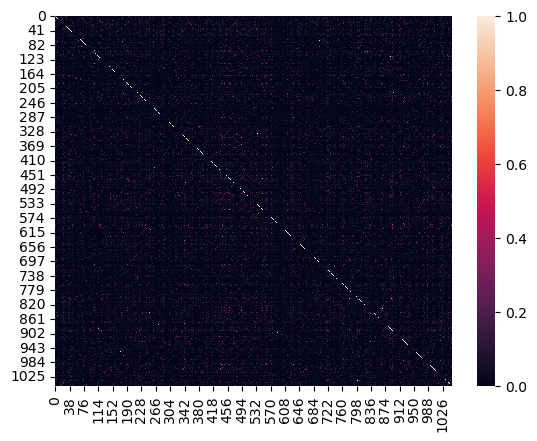

In [54]:
sns.heatmap(cosine_sim_article_titles)

Text(0.5, 0, 'Average cosine similarity with other articles')

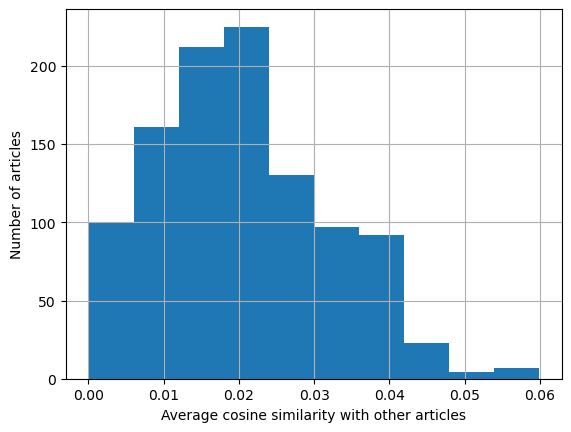

In [55]:
# compute average cosine simmilarities for all articles with all the other articles
cosine_sim_article_titles['avge_similarity'] = 0
avge_sims = []
for idx, row in cosine_sim_article_titles.iterrows():
    n_cols = len(cosine_sim_article_titles.columns) -1 # exclude recently created column
    sum_vals = 0
    for col in row.items():
        if col[0] != idx:
            sum_vals += col[1]
    avge_sims.append(sum_vals / n_cols)
cosine_sim_article_titles['avge_similarity'] = avge_sims
cosine_sim_article_titles['avge_similarity'].hist()
plt.ylabel("Number of articles")
plt.xlabel("Average cosine similarity with other articles")

Let's see below concrete similar articles pulled by cosine simmilarity. It works well in most cases.

In [56]:
def find_similar_articles(article_id, n_recs = 10, df = df_content):
    ''' Find articles with a title most similar to the input article id
    Article simmilarity is computed by cosine simmilarity between tfidf-vectorized titles. Articles with cosine simmilarity
    equal to zero are excluded
    
    INPUT:
        article_id (int)
        n_recs (int): number of similar articles to return
        df (dataframe): dataframe of records of article views, as explained above
        
    OUTPUT:
        similar_ids (list of ints): ids of simmilar articles
        similar_recs (list of strings): titles of simmilar articles
        original_title (string): title of input article for which to find simmilar articles 
    '''
    # vectorize corpus from article titles and store cosine similarity between all articles
    corpus = df['doc_full_name'].tolist()
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    cosine_sim_article_titles = pd.DataFrame(cosine_sim, columns = df['article_id'].tolist(), index = df['article_id'].tolist())
    similar_ids = cosine_sim_article_titles[article_id].sort_values(ascending=False)[1:n_recs+1].index
    similar_ids = [idx for idx in similar_ids if idx>0] # exclude articles with cosine similarity = 0
    if len(similar_ids)>0:
        similar_titles = [df[df['article_id']==idx]['doc_full_name'].values[0] for idx in similar_ids]
        original_title = df[df['article_id']==article_id]['doc_full_name'].values[0]
    else:
        similar_titles = 0
        original_title = 0
    # devuelve tambien el valor del cosine_similarity
    return original_title, similar_titles,similar_ids

In [57]:
# Simmilar articles for article id 0: fairly good result
article, similar_articles, sim_ids = find_similar_articles(article_id = 0)
print("Original: " + article)
print("\nSimilars:")
[print(article) for article in similar_articles]

Original: Detect Malfunctioning IoT Sensors with Streaming Analytics

Similars:
Data science for real-time streaming analytics
Developing for the IBM Streaming Analytics service
What’s new in the Streaming Analytics service on Bluemix
Experience IoT with Coursera
Use dashDB with Watson Analytics
Apache Spark Analytics
Use IBM Data Science Experience to detect time series anomalies
Building IoT Apps on Cloudant, with Kiwi Wearables
Show Twitter trends with Spark Streaming and IBM Watson
Analyzing streaming Data from Kafka Topics


[None, None, None, None, None, None, None, None, None, None]

In [58]:
# Similars to article 1 does not pull simmilar articles, but it brings a varied offer, which is also desirable
article, similar_articles, sim_ids = find_similar_articles(article_id = 1)
print("Original: " + article)
print("\nSimilars:")
[print(article) for article in similar_articles]

Original: Communicating data science: A guide to presenting your work

Similars:
Work with Data Connections in DSX
R for Data Science
The Definitive Guide
A Beginner's Guide to Variational Methods
A guide to convolution arithmetic for deep learning
A Quick Guide to Redis 3.2's Geo Support
A Speed Guide To Redis Lua Scripting
R Markdown Reference Guide
Upgrading your PostgreSQL to 9.5
Quick Guide to Build a Recommendation Engine in Python


[None, None, None, None, None, None, None, None, None, None]

In [59]:
# Similars to article 2: fairly good result
article, similar_articles, sim_ids = find_similar_articles(article_id = 2)
print("Original: " + article)
print("\nSimilars:")
[print(article) for article in similar_articles]

Original: This Week in Data Science (April 18, 2017)

Similars:
This Week in Data Science (April 4, 2017)
This Week in Data Science (April 11, 2017)
This Week in Data Science (April 25, 2017)
This Week in Data Science (October 18, 2016)
This Week in Data Science
This Week in Data Science (May 2, 2017)
This Week in Data Science (February 7, 2017)
This Week in Data Science (March 7, 2017)
This Week in Data Science (January 10, 2017)
This Week in Data Science (May 23, 2017)


[None, None, None, None, None, None, None, None, None, None]

In [60]:
# Similars to article 3 are ok
article, similar_articles, sim_ids = find_similar_articles(article_id = 3)
print("Original: " + article)
print("\nSimilars:")
[print(article) for article in similar_articles]

Original: DataLayer Conference: Boost the performance of your distributed database

Similars:
DataLayer Conference: Scylla, the High-Performance Cassandra-Successor
DataLayer Conference: Partial Indexing for Improved Query Performance
DataLayer Conference: Bootstrapping a Startup using Compose
DataLayer Conference: Ambry at LinkedIn
The Machine Learning Database
DataLayer Conference: Storage Wars - The Art Genome Project
DataLayer Conference: Managing (or not) the Data in Immutable Infrastructure
DataLayer Conference: Rethinking Indexing in Data Stores with Replex
DataLayer Conference: Keynote with Mitch Pirtle, CapitalOne
DataLayer Conference: Translating Backend Data to Frontend Needs


[None, None, None, None, None, None, None, None, None, None]

In [61]:
# Similars to article 4 are ok
article, similar_articles, sim_ids = find_similar_articles(article_id = 4)
print("Original: " + article)
print("\nSimilars:")
[print(article) for article in similar_articles]

Original: Analyze NY Restaurant data using Spark in DSX

Similars:
Using DSX notebooks to analyze GitHub data
Use Spark R to Load and Analyze Data
Analyze Db2 Warehouse on Cloud data in RStudio in DSX
Load and analyze public data sets in DSX
Using BigDL in DSX for Deep Learning on Spark
Analyze Market Trends in Twitter Using Apache Spark, Python, and dashDB
Analyze open data sets using pandas in a Python notebook
Build SQL queries with Apache Spark in DSX
Load Cloudant Data in Apache Spark Using a Python Notebook
Load Db2 Warehouse on Cloud data with Apache Spark in DSX


[None, None, None, None, None, None, None, None, None, None]

Below a function that makes recommendations using content similarity (cosine similarity between article title text), as well as showing popular articles and articles from similar users. Below the function cell, there are tests of each of the 3 types of users to which it is targeted: **new users** (in this situation, the function pulls popular articles), **recent users** (here, it pulls a mix of popular articles and articles similar to those few articles seen by the recent user), and **old users** (here, in addition to the previous approaches, it also pulls articles from similar users):

In [62]:
def make_content_recs(user_id, m=10):
    ''' Gives recommendations of articles customized for each type of user (new users, recent users, old users). 
    
    For new users, the most popular articles are pulled and shown ordered by popularity. 
    For recent users, popular articles as well as articles whose titles are similar to those already seen by the user. 
    For old users, in addition to the previous approaches, the system shows articles that are also seen by similar users.
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    MORE INFO:
    The aim of a recommender is to show personalized items to users based on 4 criteria:
    - relevance: show items likely to be liked by the user
    - novelty: show items that the user has never seen
    - serendipity: show items that sourprise the user. This can be implemented by offering randomly or pseudorandomly
    (pulling items from categories less interacted by the user)
    - diversity: items should be varied to avoid the user geting bored
    
    Recommender approaches used in this function:
    - Knowledge-based: takes user input about their preferences to pull items (to be applied on new users). Without 
    additional info, the idea here is to show popular articles within the categories preferred by the user, or simply 
    the most popular items across the database without considering categories.

    - Content-based: uses information about content items. Here I use this approach by computing a content similarity matrix 
    of vectorized article texts ranked based on cosine similarity. Articles without similarity 
        (cosine similarity = 0) are removed and then the most similar article titles are returned. 
    
    - Collaborative-filtering: uses information about user-item interactions, without having info about the content
    nor the users. Throughout this notebook I use 2 different approaches:
        * neighbor-based approach: pull items liked by similar users (we assume that seeing/reading an article = the user 
        has liked it). 
        * model-based (matrix factorization via SVD): this will come below in section 5. The idea is 
        to predict ratings of each user for each content item, which allows to measure the goodnes of the recommender system
        by comparing predicted with actual ratings. 
        Here, we will pull items from user or item neighbours, ordered by popularity, 
        without knowing if the user will like those items or not.
    
    
    '''
    popular_articles_ids = get_top_article_ids(m)
    popular_articles_names = get_top_articles(m)
    
    
    ''' new users (no articles read yet) -> popular items
    ''' 
    if user_id not in df['user_id'].unique():
        recs = popular_articles_ids
        rec_names = popular_articles_names
    else:
        recs = []
        # get articles read by user:
        seen_ids = get_user_articles(user_id)
        # remove articles not present in df_content (no similarity can be analysed)
        seen_ids = [idx for idx in seen_ids if int(float(idx)) in df_content['article_id'].unique()]
        # sort articles seen by number of views
        df_views_articles = df[['article_id','title']].groupby(['article_id']).count().rename(columns={'title':'n_views'})
        sorted_articles = df_views_articles[df_views_articles.index.isin([int(float(idx)) for idx in seen_ids])].sort_values(by='n_views', ascending=False).index.tolist()           
        
        ''' Recent users (less than 5 articles read) -> up to 80% similar articles, at least 20% popular items 
        5 is an arbitrary threshold, could be optimized, but visual exploration suggest it is ok
        '''
        if len(sorted_articles) < 6:
            # collect similar articles 
            for article in sorted_articles:
                # find similar articles (4 for each seen article, to add variety)
                similar_ids = find_similar_articles(article_id = article, n_recs = 4)[2]
                # store and remove those already seen by user
                recs.extend(similar_ids)
                recs = list(set(recs) - set(seen_ids))        
                # if number of collected recommendations exceeds m, stop loop
                if len(recs) > int(0.8 * m) -1 :
                    recs = recs[:int(0.8 * m)]
                    break       
        else:
            ''' old users (more than 5 articles read) -> up to 50% similar articles, at least 50% articles from simmilar 
            users, until 100% popular items '''
            
            # similar articles (content similarity)
            for article in sorted_articles:
                # find similar articles (2 for each seen article, to add variety)
                similar_ids = find_similar_articles(article_id = article, n_recs = 2)[2]
                # store and remove those already seen by user
                recs.extend(similar_ids)
                recs = list(set(recs) - set(seen_ids))        
                # if number of collected recommendations exceeds m, stop loop
                if len(recs) > int(0.5 * m) -1 :
                    recs = recs[:(int(0.5 * m) -1)]
                    break 
            
            # articles from similar users      
            similar_users = get_top_sorted_users(user_id, df=df).index.tolist()
            for user in similar_users:
                #print("\nUser: {}, type: {}".format(user, type(user)))
                # convert user to integer to be able to find it in 'df_users_items' in get_user_articles() function
                #user = int(user)
                # For each user get his/her articles
                new_ids = get_user_articles(user)
                # sort articles by number of views
                new_ids = [int(float(idx)) for idx in new_ids]
                sorted_articles_user = df_views_articles[df_views_articles.index.isin(new_ids)].sort_values(by='n_views', ascending=False).index.tolist()
                # save ids in recs
                recs.extend(sorted_articles_user)
                # remove articles already seen by input user
                recs = list(set(recs) - set(seen_ids))
                # if number of collected recommendations exceeds m, stop loop
                if len(recs) > m-2:
                    recs = recs[:m-2]
                    break
        
        # Finally, for both old and recent users, after collecting similar articles (content or user similarity), 
        # add popular articles to recs
        if len(recs)< m:
            for idx in popular_articles_ids:
                recs.append(idx)
                if len(recs) > m-1:
                    break

    # convert ids back to string and get only those requested by m
    recs = [str(idx) for idx in recs][:m]
    #print(recs)
    rec_names = get_article_names(recs, df=df)   
    return recs, rec_names
    #return recs

In [63]:
# user_id = 0 does not exist -> new user -> popular articles
make_content_recs(0)[1]

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [64]:
# user_id = 3381 has seen 5 articles -> recent user (pull 8 similar articles, the last 2 are popular articles).
make_content_recs(3381)[1]

['back to basics — jupyter notebooks',
 'Introducing IBM Graph',
 'Introducing Cloudant Local',
 'jupyter (ipython) notebooks features',
 'Introducing Cloudant Geospatial',
 'enjoy python 3.5 in jupyter notebooks',
 'Introducing Cloudant Query',
 'tidy data in python',
 'use deep learning for image classification',
 'insights from new york car accident reports']

In [65]:
# user_id = 1157 has seen 5 articles -> recent user (pull 8 similar articles, the last 2 are popular articles).
make_content_recs(1157)[1]

['random forest interpretation – conditional feature contributions',
 'the random forest algorithm ',
 "a beginner's guide to variational methods",
 'variational auto-encoder for "frey faces" using keras',
 'jupyter notebook tutorial',
 'predicting flight cancellations using weather data, part 3',
 'some random weekend reading',
 'adoption of machine learning to software failure prediction',
 'use deep learning for image classification',
 'insights from new york car accident reports']

In [66]:
# user_id = 1157 has seen 1 article -> recent user (pull 4 similar articles, the last 6 are popular articles).
make_content_recs(5149)[1]

['build a logistic regression model with wml & dsx',
 'the greatest public datasets for ai – startup grind',
 'how to perform a logistic regression in r',
 'a comparison of logistic regression and naive bayes ',
 'use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo']

In [67]:
# user_id = 23 has seen 135 articles -> old user (pull 4 similar articles, 4 articles from similar users, 
# and 2 popular articles).
make_content_recs(23)[1]

['data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'shaping data with ibm data refinery',
 'data science platforms are on the rise and ibm is leading the way',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'use deep learning for image classification',
 'insights from new york car accident reports']

In [68]:
# user_id = 3764 has seen 97 articles -> old user (pull 4 similar articles, 4 articles from similar users, 
# and 2 popular articles).
make_content_recs(3764)[1]

['using deep learning to reconstruct high-resolution audio',
 'data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'share the (pixiedust) magic – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'working interactively with rstudio and notebooks in dsx',
 'a comparison of logistic regression and naive bayes ',
 'use deep learning for image classification',
 'insights from new york car accident reports']

In [69]:
# user_id = 3190 has seen 6 articles -> old user (pull 4 similar articles, 4 articles from similar users, 
# and 2 popular articles).
make_content_recs(3190)[1]

['the random forest algorithm ',
 'Improved Performance for Redis Cache Mode on Compose',
 'Finding the Mode in PostgreSQL',
 'Mongo Metrics: Calculating the Mode',
 'ibm-cds-labs/hybrid-cloud-tutorial',
 'random forest interpretation – conditional feature contributions',
 'jupyter notebook tutorial',
 'some random weekend reading',
 'use deep learning for image classification',
 'insights from new york car accident reports']

`2.` Summary of the content based recommender system above:

The function above gives a combination of 3 recommendation approaches (ppopular, content-based and collaborative filtering) tailored to 3 different types of users, with the aim of giving recommendations that, regardless of user type, are always relevant, new to the user, and are varied:
- New users: as there are no data about user preferences, recommendations are the most popular articles in the platform
- Recent users: if the user has read 5 articles or less, the recommendations include up to 80% of articles similar to those seen by the user (computed by cosine similarity on tfidf-vectorized articles text) and at least 20% of popular articles. For similar articles, articles seen by user are first sorted by the number of views of each article and then, starting with the most popular, similar articles (up to a maximum of 4) are pulled from each one of those articles, to bring more variety.
- Old users: for users that have seen more than 5 articles, we add to the previous approaches a layer of recommendations pulled from similar users. The 3 approaches are blended to give variety, but prioritizing content similarity (40% of recommendations), then articles from similar users (40% of recommendations), and finally adding at least a 20% of popular articles. Such proportional mixture is made in each call to the recommendations generator function.

One way to improve the funtion above is by measuring the goodness of the recommendation system. One way to to so is by making predicitions and comparing them with actual results observed from user behavior. Once we have a system with enough accurate predictions, we could use them to further refine the recommendations by subselecting those articles that are not only simmilar or popular, but are predicted to be liked by the user

`3.` Let's test the recommendation system to make recommendations for some additional scenarios:

In [70]:
# make recommendations for a brand new user
make_content_recs(50000)[1]

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [71]:
# make recommendations for a user who only has interacted with article id '1427.0'
# Let's identify those users
for user in set(df[df['article_id']==1427]['user_id'].tolist()): # users that have seen article 1427
    seen_ids = get_user_articles(user)
    if len(seen_ids) == 1:
        print("user id : {}, number of articles seen: {}".format(user, len(seen_ids)))

user id : 2234, number of articles seen: 1
user id : 2360, number of articles seen: 1
user id : 331, number of articles seen: 1
user id : 348, number of articles seen: 1
user id : 504, number of articles seen: 1
user id : 2595, number of articles seen: 1
user id : 2597, number of articles seen: 1
user id : 2820, number of articles seen: 1
user id : 2825, number of articles seen: 1
user id : 2835, number of articles seen: 1
user id : 2838, number of articles seen: 1
user id : 3630, number of articles seen: 1


In [72]:
# Article 1427 is not in df_content, therefore even if the user is from category "recent users", 
# the recommendations for those users who only have interacted with artcile 1427 will be as if they were "new users"
# because there is no content simmilarity to compute
len(df_content[df_content['article_id']==1427])

0

In [73]:
make_content_recs(2234)[1]

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, I use matrix factorization to predict articles that will be liked by the users on the IBM Watson Studio platform. Let's load the user-item matrix created above (in question 1, part III)

In [74]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [75]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, I can use Singular Value Decomposition (SVD) from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix (next cell code, explanation below):

In [76]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

The reason why we can use SVD in this situation is that there are no missing values in the user item-matrix. Such matrix here has 2 possible values: 1 if the user has viewed the article, 0 otherwise. In other circumstances, for example if we had a matrix of ratings (ranging from 0-10) instead of binary-encoded views events (with only 2 possible values, as explained), or if we had missing values because of users not having rated certain items, then we could not use SVD directly from numpy, but we could have used an iterative approach such as FunkSVD. Here, as said, we can directly use SVD because we are predicting user views of articles, not a specific rating.

SVD assumes that similar users interact similarly with similar items, based on the existence of latent factors that explain the relationship between users and items. Indeed, by assuming a number of latent factors, we can mathematically predict the original user-item matrix by linear algebra (cell above) on a subset of data and then compare it with actual results to establish the accuracy of the prediction.

In [77]:
# Confirm there are no missing values in the user-item matrix
np.isnan(user_item_matrix).sum().sum()

0

`3.` Now, how do we choose the number of latent features to use? The cell below shows that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

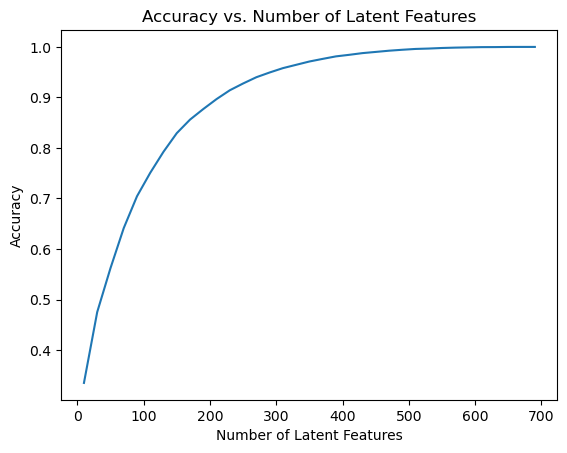

In [78]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` Next, let's split our dataset into a training and test set of data, as shown in the cell below, to measure the accuracy of the prediction and how it is affected by choosing different number of latent factors. 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [79]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test['user_id'].unique().tolist()
    test_arts = df_test['article_id'].unique().tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [80]:
# how many users in test set we could make predictions for? -> those users in test set that are also in the train set
train_idx = df_train['user_id'].unique().tolist()
test_users_predicted = [user for user in test_idx if user in train_idx]
n_test_users_predicted = len(test_users_predicted)
n_test_users_predicted

20

In [81]:
# users in test set we could not make predictions because of the cold-start problem:
n_test_users_no_predicted = len(test_idx) - n_test_users_predicted
n_test_users_no_predicted

662

In [82]:
# articles in test set we could make predictions -> those in the test set that are also in the train set:
train_arts = df_train['article_id'].unique().tolist()
test_articles_predicted = [article for article in test_arts if article in train_arts]
n_test_articles_predicted = len(test_articles_predicted)
n_test_articles_predicted

574

In [83]:
# articles in test set we could not make predictions because of the cold-start problem:
n_test_arts_no_predicted = len(test_arts) - n_test_articles_predicted
n_test_arts_no_predicted

0

In [84]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now let's explore how well SVD works towards making predictions for recommendations on the test data.  Let's find U, S and V transpose using SVD on user_item_train and then compare the predicted data with the actual data in user_item_test to see how accuracy is affected by the number of latent factors.

In [85]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

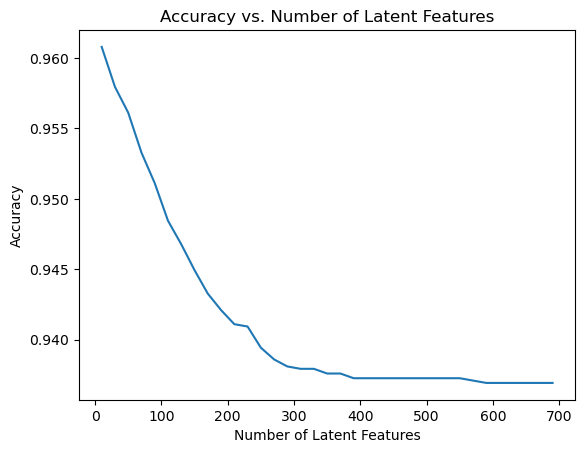

In [86]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

# localize rows and columns in training and test sets that were predicted and can be compared
user_item_train_df = create_user_item_df(df_train)
user_item_test_df = create_user_item_df(df_test)
predicted_rows_train = user_item_train_df.index.get_indexer(test_users_predicted)
predicted_cols_train = user_item_test_df.columns.get_indexer(test_articles_predicted)
predicted_rows_test = user_item_test_df.index.get_indexer(test_users_predicted)

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # extract values from estimated train set for users and articles in test set (= estimated test set)
    user_item_est_train_compare = user_item_est_train[predicted_rows_train,:]
    user_item_est_train_compare = user_item_est_train_compare[:, predicted_cols_train]
    
    # extract values from actual test set that were predicted
    user_item_test_predicted = user_item_test[predicted_rows_test,:]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_predicted, user_item_est_train_compare)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_test.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Comment on the results: are we improving how users currently find articles? 

As shown in the plot above, the prediction based on SVD has quite high accuracy. Even if accuracy decreases as the number of latent features increases, the decay seems quite small. It seems that taking 300 latent features may be a good number as further increasing this number does not bring additional change in accuracy, and looking at the corresponding plot done with the entire dataset also supports this. Nevertheless, the decrease in accuracy from 10 latent factors to 300 is quite small, so even the lower number could be appropriate. Performance factors may come to help make the decision on how many latent factors to use.

Thus, it seems we have a quite accurate prediction system that we could use to refine the recommendations (see below). Nevertheless, we should acknoweldge that so far we are drawing conclusions only from 20 users in which we could make predictions. Also, we do not know what actually a decay of accuracy from 0.96 with 10 latent factors to 0.935 with 300 latent factors means practically (would that make users dissapointed?). Therefore, we should collect more data to confirm the above accuracy. It should also be analysed how increasing the number of latent factors to up to 300 impacts the speed at which recommendations are pulled and presented. Additionally, at the very end, after deployment we should also measure that adding a recommender system will actually increase econometric measures of success, for example, the amount of unique articles viewed by each user, time using the platform, or conversion measures if applicable (% purchases, clicks on ads, etc).

### Final recommender

The final recommender will combine all of the approaches used before. SVD can be used to add another layer of filtering to ensure relevance of recommended articles by removing those articles not predicted to be liked by the user. In this particular case, it will be used to filter the movies from which to pull items when looking at articles from similar users. The final function is below:

In [87]:
def predicted_articles_ids_svd(user_id, user_item_matrix=user_item_matrix, k=300):
    ''' Returns articles ids predicted by SVD to be liked by user
    INPUT:
        user_id (int): id of user on whom to predict liked articles
        user_item_matrix (2D numpy array): matrix of user-item interactions (unique users for each row and unique articles for each column)
        k (int): number of latent factors to use in SVD
        
    OUTPUT:
        predicted_articles_ids (list of integers): id of articles predicted to be liked for the input user_id
    '''
    # matrix factorization
    u, s, vt = np.linalg.svd(user_item_matrix)
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # obtain predicted user-articles matrix
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
            
    # get list of articles ids predicted to be liked by user
    est_user_row = user_item_est[user_item_matrix.index.get_loc(user_id),:]
    df_pred = pd.DataFrame(est_user_row, index=user_item_matrix.columns)
    predicted_articles_ids = df_pred.loc[df_pred[0]==1].index.tolist()
    predicted_articles_ids = [int(float(idx)) for idx in predicted_articles_ids]
        
    return predicted_articles_ids

In [88]:
def final_recommender(user_id, m=10, user_item_matrix=user_item_matrix, k=300, df=df, df_content=df_content, dot_prod_df = dot_prod_df):
    ''' Gives a recommendation of articles customized for each type of user (new users, recent users, old users). 
    
    For new users, the most popular articles are pulled and shown ordered by popularity. 
    For recent users, popular articles as well as articles whose titles are similar to those already seen by the user. 
    For old users, in addition to the previous approaches, the system shows
    articles that are also seen by similar users removing those not predicted to be liked by matrix factorization with SVD.
    
    INPUT:
        user_id - (int) a user id
        m - (int) the number of recommendations you want for the user
        user_item_matrix (2D numpy array): matrix of user-item interactions (unique users for each row and unique articles 
        for each column)
        k (int): number of latent factors to use in SVD
    
    OUTPUT:
        recs - (list) a list of recommendations for the user by article id
        rec_names - (list) a list of recommendations for the user by article title
    
    '''
    popular_articles_ids = get_top_article_ids(m, df=df)
    popular_articles_names = get_top_articles(m, df=df)
    
    
    ''' new users (no articles read yet) -> popular items
    ''' 
    if user_id not in df['user_id'].unique():
        recs = popular_articles_ids
        rec_names = popular_articles_names
    else:
        recs = []
        # get articles read by user:
        seen_ids = get_user_articles(user_id, user_item=user_item_matrix)
        # remove articles not present in df_content (no similarity can be analysed)
        seen_ids = [idx for idx in seen_ids if int(float(idx)) in df_content['article_id'].unique()]
        # sort articles seen by number of views
        df_views_articles = df[['article_id','title']].groupby(['article_id']).count().rename(columns={'title':'n_views'})
        sorted_articles = df_views_articles[df_views_articles.index.isin([int(float(idx)) for idx in seen_ids])].sort_values(by='n_views', ascending=False).index.tolist()           
        
        ''' Recent users (less than 5 articles read) -> up to 80% similar articles, at least 20% popular items 
        5 is an arbitrary threshold, could be optimized, but visual exploration suggest it is ok
        '''
        if len(sorted_articles) < 6:
            # collect similar articles 
            for article in sorted_articles:
                # find similar articles (4 for each seen article, to add variety)
                similar_ids = find_similar_articles(article_id = article, n_recs = 4, df=df_content)[2]
                # store and remove those already seen by user
                recs.extend(similar_ids)
                recs = list(set(recs) - set(seen_ids))        
                # if number of collected recommendations exceeds m, stop loop
                if len(recs) > int(0.8 * m) -1 :
                    recs = recs[:int(0.8 * m)]
                    break       
        else:
            ''' old users (more than 5 articles read) -> up to 50% similar articles, at least 50% articles from simmilar 
            users, filtered by SVD-prediction, and until 100% popular items '''
            
            # similar articles (content similarity)
            for article in sorted_articles:
                # find similar articles (2 for each seen article, to add variety)
                similar_ids = find_similar_articles(article_id = article, n_recs = 2, df=df_content)[2]
                # store and remove those already seen by user
                recs.extend(similar_ids)
                recs = list(set(recs) - set(seen_ids))        
                # if number of collected recommendations exceeds m, stop loop
                if len(recs) > int(0.5 * m) -1 :
                    recs = recs[:(int(0.5 * m) -1)]
                    break 
            
            # articles from similar users      
            similar_users = get_top_sorted_users(user_id, df=df, users_similarity = dot_prod_df).index.tolist()
            
            # compute SVD-predicted user-item matrix
            predicted_articles = predicted_articles_ids_svd(user_id, user_item_matrix=user_item_matrix, k=k)
            
            for user in similar_users:
                # For each user get his/her articles
                new_ids = get_user_articles(user, user_item=user_item_matrix)
                new_ids = [int(float(idx)) for idx in new_ids]
                # filter out articles not predicted to be liked by svd
                filtered_ids = [idx for idx in new_ids if idx in predicted_articles]
                # sort articles by number of views
                sorted_articles_user = df_views_articles[df_views_articles.index.isin(filtered_ids)].sort_values(by='n_views', ascending=False).index.tolist()
                # save ids in recs
                recs.extend(sorted_articles_user)
                # remove articles already seen by input user
                recs = list(set(recs) - set(seen_ids))
                # if number of collected recommendations exceeds m, stop loop
                if len(recs) > m-2:
                    recs = recs[:m-2]
                    break
        
        # Finally, for both old and recent users, after collecting similar articles (based on content or user similarity), 
        # add popular articles to recs
        if len(recs)< m:
            for idx in popular_articles_ids:
                recs.append(idx)
                recs = list(set(recs) - set(seen_ids))
                if len(recs) > m-1:
                    break

    # convert ids back to string and get only those requested by m
    recs = [str(idx) for idx in recs][:m]
    rec_names = get_article_names(recs, df=df)   
    return recs, rec_names

As shown below, the results of this function and the previous one without SVD are quite similar. Let's pull both results for an old user, the only situation where there could be any difference between SVD and non-SVD recommenders. Indeed, the new function only slightly changes the order of recommendations.

In [89]:
# Recommender without SVD. user_id = 3764 has seen 97 articles -> old user (pull 4 similar articles, 4 articles from similar users, 
# and 2 popular articles).
make_content_recs(3764)[1]

['using deep learning to reconstruct high-resolution audio',
 'data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'share the (pixiedust) magic – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'working interactively with rstudio and notebooks in dsx',
 'a comparison of logistic regression and naive bayes ',
 'use deep learning for image classification',
 'insights from new york car accident reports']

In [90]:
# New function here
final_recommender(3764)[1]

['using deep learning to reconstruct high-resolution audio',
 'data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'share the (pixiedust) magic – ibm watson data lab – medium',
 'insights from new york car accident reports',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'working interactively with rstudio and notebooks in dsx',
 'a comparison of logistic regression and naive bayes ',
 'use deep learning for image classification']

### <a class="anchor" id="oop">Part VI: Recommender class (OOP)</a>
Finally, let's wrap up everything into a class to make new predictions and update the results based on user activity. Finally, let's deploy the recommender in a webapp on streamlit.

Let's first create a class that shows recommendations for a new user and stores what articles the user picks and updates recommendations accordingly using the final recommender function above. Thus, we need to update the df dataframe, but we do not write the file, so the recommender adapts only during a single session.

In [91]:
class Recommender():
    ''' Makes recommendations of articles from IBM Watson Studio platform using a combination of ranked-based recommendations, 
    content-based recommendations and collaborative-filtering.
    
    For new users, the recommender shows popular articles.
    
    Once a user starts viewing articles, those articles are recorded to recommends articles which text title is simmilar.
    
    Once a user has seen more than 5 articles, the engine starts looking at similar users to pull articles seen by those, 
    among which only those predicted to be liked by the user via SVD factorization of the user-item matrix are shown.
    
    '''
    def __init__(self):
        ''' Instantiates a recommender object, load the datasets and pre-process them to have the recommender function ready
        '''
        # load datasets
        self.df = pd.read_csv('data/user-item-interactions.csv')
        self.df_content = pd.read_csv('data/articles_community.csv')
        del self.df['Unnamed: 0']
        del self.df_content['Unnamed: 0']
        
        # Remove any rows that have the same article_id - only keep the first
        self.df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)
        
        # map user email to create new user_id column
        email_encoded = email_mapper(df=self.df)
        del self.df['email']
        self.df['user_id'] = email_encoded
        
        # create or load user_item matrix
        #user_item_df = create_user_item_df(df) 
        self.user_item_matrix = pd.read_pickle('user_item_matrix.p')
        
        # load users similarity (dot_product) dataframe
        self.dot_prod_df = pd.read_csv('users_dot_product.csv')
        self.dot_prod_df.set_index('user_id', inplace=True)
    
    def make_recommendations(self, user_id, m=10, k=300):
        ''' Makes recommendations for a given user_id
        
        INPUT:
            user_id (int): user for whom to make recommendations
        OUTPUT
            None, but stores the titles of recommended articles in the 'recommended_articles' attribute
        '''
        self.recommended_articles = final_recommender(user_id, m=m, k=k, user_item_matrix = self.user_item_matrix, df=self.df, df_content=self.df_content, dot_prod_df=self.dot_prod_df)
        

In [92]:
rec = Recommender()

In [93]:
rec.make_recommendations(user_id=0)
rec.recommended_articles[1]

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [94]:
rec.make_recommendations(user_id=3764)
rec.recommended_articles[1]

['using deep learning to reconstruct high-resolution audio',
 'data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'share the (pixiedust) magic – ibm watson data lab – medium',
 'insights from new york car accident reports',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'working interactively with rstudio and notebooks in dsx',
 'a comparison of logistic regression and naive bayes ',
 'use deep learning for image classification']

### <a class="anchor" id="deployment">Part VII: Deployment</a>

Using the recommender class above, I have built a website app in Streamlit to showcase its functionality and results. The app let's you choose a user type (new user, recent user, old user) and shows read items and recommendations for a randomly selected user id of the selected user type. Of note, the recommender class has to be wrapped in a Streamlit session state variable to be able to update the dataframe attribute of the recommender object.

Visit it [here](https://recommender-ibm-watson.streamlit.app/).

### <a class="anchor" id="conclusions">Part VIII: Conclusions</a>
In summary, I have built a recommendation engine using content based and collaborative filtering approaches. Concerning content based recommendation, my approach consists of pulling items with titles similar to articles already seen by the user (similar articles). Concerning collaborative filtering, I use both user-user similarity (similar users) and I also predict items to be liked by taking past user-item interactions and factorizing the user-item matrix using Single Value Decomposition (SVD). I also use rank-based filtering of items to show when we do not have enough information about past user activity (popular items).<br>

The aim of a recommender is to show personalized items to users to maximize the following 4 goals:
- Relevance: show items likely to be liked by the user
- Novelty: show items that the user has never seen
- Serendipity: show items that sourprise the user. This can be implemented by offering randomly or pseudorandomly
    (pulling items from categories less interacted by the user)
- Diversity: items should be varied to avoid the user geting bored
    
Background information about the different recommender approaches that exist, some of which are used in this project:
- Knowledge-based recommendations: takes user input about their preferences to pull items (to be applied on new users). Without 
    additional info, the idea here is to show popular articles within the categories preferred by the user, or simply 
    the most popular items across the database without considering categories.

- Content-based recommendations: uses information about users or about content items. Here we use this by computing similarities between content items. By using NLP, the title text of each article is vectorized and simmilarities with all the other articles are calculated by computing the cosine similarity. Articles without similarity (cosine similarity = 0) are removed and then the most similar article titles are returned. 
    
- Collaborative-filtering: uses information about user-item interactions, without having info about the content nor the users. Here I use 2 different approaches:
    * Neighbor-based approach: pull items liked by similar users (we assume that seeing/reading an article = the user 
        has liked it). I compute similarities between users, i.e. user-user closeness, based on the articles they have read. This leads to pulling article items read by the most similar users.
    * Model-based (matrix factorization via SVD): here I reconstruct a user-item matrix to predict articles that will be liked by a given user based on items liked by similar users. As shown before, SVD with 300 latent factors gives an accuracy near to 0.94

Below some issues and possible improvements.

Difficult aspects:
- Given the overal sparse and low similarity of content items and users with other content items and users, SVD does not work with this dataset. By checking the recommender function carefully, it turns out that SVD simply pulls the items already seen by the user, but does not predict anything new (regardless of the number of latent factors chosen). For this reason, and since SVD is the most time consuming process among all code in the recommender object, in the final class deployed in Streamlit I have added an if statement to run SVD only when the user is very active (has seen over 100 content items).
- Streamlit development: Streamlit runs the code entirely from top to bottom every time there is interaction with input elements (i.e. you click at any button to add items to the "seen" list or you interact with the slider to set the number of articles to show). For this reason, the code needs to be writen in a way that is sometimes not very intuitive and use session_state variables to store certain data during the time the visitor is using the webapp. Otherwise, it is a fantastic library that makes relatively easy to deploy a web app with Python.

Potential improvements:
- Add more types of users: this could help fix why SVD does not work with this dataset, as well as adding more users and more interactions so that the user-item matrix has more commonalities.
- Randomize or pseudorandomize items to show among the top 50 or top 100 items, to add more variety and serendipity.